<a href="https://colab.research.google.com/github/nmcardoso/galmorpho/blob/master/splus_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x 
import random
import tensorflow as tf
import numpy as np
import os
import glob
import multiprocessing as mp
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from keras import backend as K
from keras import layers
from keras import models
from keras import optimizers
from keras import utils
from keras import applications
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications import VGG16
from keras.applications import ResNet50V2
from progressbar import progressbar
from keras.utils import np_utils
import requests

!pip3 install git+https://github.com/nmcardoso/fitsbook-python
import fitsbook as fb

In [ ]:
# Reprodutibilidade
# https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

os.environ['PYTHONHASHSEED'] = '12'
np.random.seed(123)
random.seed(1234)
tf.set_random_seed(12345)

# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, 
#                               inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)

print('Sementes Plantadas!')

Sementes Plantadas!


## Preparação dos dados

In [ ]:
!cp "/content/drive/My Drive/splus_data/datasets/splus_64px_12ch.tar.xz" dataset.tar.xz
!cp "/content/drive/My Drive/splus_data/datasets/train_table.csv" /content
!cp "/content/drive/My Drive/splus_data/datasets/val_table.csv" /content
!cp "/content/drive/My Drive/splus_data/datasets/test_table.csv" /content

In [ ]:
!tar -xf dataset.tar.xz

In [ ]:
class NpySequence(utils.Sequence):
  """Generate data for Keras"""
  def __init__(self, X, labels, classes, image_size=(256, 256), channels=3, batch_size=32, output_channels=3, channel_range=None):
    self.X = X
    self.labels = self.__to_categorical(labels, classes)
    self.image_size = image_size
    self.channels = channels
    self.output_channels = output_channels
    self.channel_range = channel_range
    self.batch_size = batch_size
    self.indexes = [i for i in range(len(X[0]))] # X[0] - photometric
    np.random.shuffle(self.indexes)
  
  def __len__(self):
    """The number of batches per epoch"""
    # return int(np.floor(len(self.X[0]) / self.batch_size)) - with photometric
    return int(np.floor(len(self.X) / self.batch_size))
  
  def __getitem__(self, index):
    """Generate one batch of data"""
    partition = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
    X, Y = self.__data_generation(partition)
    if self.channel_range:
      return X[..., self.channel_range[0]:self.channel_range[1]], Y
    elif self.channels > self.output_channels:
      return [X[..., 0:3], X[..., 3:6], X[..., 6:9], X[..., 9:12], self.__get_photo_data(partition)], Y
    else:
      return X, Y
  
  def on_epoch_end(self):
    """Shuffle files list and remap labels"""
    np.random.shuffle(self.indexes)
    
  def __to_categorical(self, labels, classes):
    """Labels to numbers"""
    classes_dict = {c:i for i,c in enumerate(classes)}
    return [classes_dict[l] for l in labels]

  def __data_generation(self, partition):
    """Load npy file and associate with a label"""
    X = np.empty((self.batch_size, *self.image_size, self.channels))
    Y = np.empty((self.batch_size,), dtype=int)

    for i, index in enumerate(partition):
      # X[i,] = np.load(self.X[0][index]) - with photometric
      X[i,] = np.load(self.X[index])
      Y[i] = self.labels[index]

    return X, Y

  def __get_photo_data(self, partition):
    X = []
    for i, index in enumerate(partition):
      X.append(self.X[1][index])
    return np.array(X)

In [ ]:
class NpySequence2(utils.Sequence):
  """Generate data for Keras
  Source: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly"""
  def __init__(self, X, Y, image_size=(256, 256), num_channels=3, channels=[], split=False, batch_size=32):
    self.X = X
    self.Y = Y
    self.image_size = image_size
    self.num_channels = num_channels
    self.channels = channels
    self.batch_size = batch_size
    self.split = split
    self.indexes = [i for i in range(len(X))]
    np.random.shuffle(self.indexes)
  
  def __len__(self):
    """The number of batches per epoch"""
    return int(np.floor(len(self.X) / self.batch_size))
  
  def __getitem__(self, index):
    """Generate one batch of data"""
    partition = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
    X, Y = self.__data_generation(partition)

    if self.split:
      return [X[..., 0:3], X[..., 3:6], X[..., 6:9], X[..., 9:12]], Y

    return X, Y
  
  def on_epoch_end(self):
    """Shuffle files list and remap labels"""
    np.random.shuffle(self.indexes)

  def __data_generation(self, partition):
    """Load npy file and associate with a label"""
    X = np.empty((self.batch_size, *self.image_size, self.num_channels))
    Y = np.empty((self.batch_size,), dtype=int)

    if not self.channels:
      for i, index in enumerate(partition):
        X[i,] =  np.load(self.X[index])
        Y[i] = self.Y[index]
    else:
      for i, index in enumerate(partition):
        X[i,] =  np.take(np.load(self.X[index]), self.channels, axis=2)
        Y[i] = self.Y[index]

    return X, np_utils.to_categorical(Y, num_classes=2)

## Modelos

### Não usados

In [ ]:
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
  # 1x1 conv
  conv1 = layers.Conv2D(f1, (1, 1), padding='same', activation='relu')(layer_in)

  # 3x3 conv
  conv3 = layers.Conv2D(f2_in, (1, 1), padding='same', activation='relu')(layer_in)
  conv3 = layers.Conv2D(f2_out, (3, 3), padding='same', activation='relu')(layer_in)

  # 5x5 conv
  conv5 = layers.Conv2D(f3_in, (1, 1), padding='same', activation='relu')(layer_in)
  conv5 = layers.Conv2D(f3_out, (5, 5), padding='same', activation='relu')(conv5)

  # 3x3 max pooling
  pool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(layer_in)
  pool = layers.Conv2D(f4_out, (1, 1), padding='same', activation='relu')(pool)

  # concatenate filters, assumes filters/channels last
  layer_out = layers.concatenate([conv1, conv3, conv5, pool], axis=-1)
  return layer_out

def compile_inception_model(image_size):
  input_layer = layers.Input(shape=image_size + (3,))
  conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
  pool1 = layers.MaxPool2D((2, 2))(conv1)
  conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
  pool2 = layers.MaxPool2D((2, 2))(conv2)
  iblock1 = inception_module(input_layer, 32, 48, 64, 8, 16, 16)
  iblock2 = inception_module(iblock1, 64, 48, 96, 16, 48, 32)
  flatten = layers.Flatten()(iblock2)
  dense1 = layers.Dense(1024, activation='relu')(flatten)
  dropout1 = layers.Dropout(.3)(dense1)
  dense2 = layers.Dense(512, activation='relu')(dropout1)
  dropout2 = layers.Dropout(.3)(dense2)
  dense3 = layers.Dense(256, activation='relu')(dropout2)
  dropout3 = layers.Dropout(.3)(dense3)
  output = layers.Dense(1, activation='sigmoid')(dropout3)
  model = models.Model(inputs=input_layer, outputs=output)
  model.name = 'splus_inception'
  utils.plot_model(model, to_file='model.png')
  model.compile(optimizer=optimizers.RMSprop(lr=5e-5),
                loss='binary_crossentropy',
                metrics=['acc'])
  return model

def compile_inception_pretrained(image_size):
  base_model = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

  x = base_model.output
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(512, activation='relu')(x)
  x = layers.Dropout(.5)(x)
  x = layers.Dense(256, activation='relu')(x)
  x = layers.Dropout(.5)(x)
  output = layers.Dense(1, activation='sigmoid')(x)

  model = models.Model(inputs=base_model.input, outputs=output)
  model.name = 'splus_inception_pretrained'

  for layer in base_model.layers:
    layer.trainable = False
  
  model.compile(optimizer=optimizers.RMSprop(lr=5e-5),
                loss='binary_crossentropy',
                metrics=['acc'])
  
  return model

def compile_VGG16(image_size):
  model = models.Sequential()
  model.name = 'splus_vgg16_impl'
  model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(image_size + (3,))))
  model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
  model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
  model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
  model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
  model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
  model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
  model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(2048, activation='relu'))
  model.add(layers.Dropout(.5))
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.Dropout(.5))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
                loss='binary_crossentropy',
                metrics=['acc'])
  return model

def compile_multidim_model(image_size):
  input_tensor = layers.Input(shape=image_size + (1,))

  branch_outputs = []
  for i in range(3):
    out = layers.Lambda(lambda x: x[:, i])(input_tensor)
    out = layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_size + (1,)))(out)
    out = layers.MaxPooling2D((2, 2))(out)
    out = layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(image_size + (1,)))(out)
    out = layers.MaxPooling2D((2, 2))(out)
    out = layers.Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=(image_size + (1,)))(out)
    out = layers.MaxPooling2D((2, 2))(out)
    branch_outputs.append(out)
  
  x = layers.Concatenate()(branch_outputs)
  x = layers.Flatten()(x)
  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(.5)(x)
  x = layers.Dense(512, activation='relu')(x)
  x = layers.Dropout(.5)(x)
  x = layers.Dense(256, activation='relu')(x)
  x = layers.Dropout(.5)(x)
  x = layers.Dense(1, activation='sigmoid')(x)

  model = models.Model(inputs=input_tensor, outputs=x)
  model.name = 'splus_multidim_conv'
  model.compile(optimizer=optimizers.RMSprop(lr=5e-5),
                loss='binary_crossentropy',
                metrics=['acc'])
  utils.plot_model(model, to_file='model.png')
  return model

### Usados

In [ ]:
def compile_parallel_model(image_size, channels=3):
  # inception_model = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=image_size + (3,))
  # for layer in inception_model.layers:
  #     layer.trainable = False

  # input_layer = layers.Input(shape=image_size + (channels,))
  branch_outputs = []
  inputs = []
  for i in range(int(channels / 3)):
    # x = layers.Lambda(lambda t: t[..., (i * 3):(i * 3 + 2)])(input_layer)
    # base_model = applications.InceptionV3(weights='imagenet', include_top=False, input_tensor=x)
    # for layer in base_model.layers:
    #   layer.trainable = False
    # j = inception_model.output
    # x = layers.GlobalAveragePooling2D()(j)
    input_layer = layers.Input(shape=image_size + (3,), name=f'InputImage_{i + 1}')
    inputs.append(input_layer)
    x = layers.Conv2D(32, (3, 3), activation='relu', name=f'Conv2D_{i + 1}1')(input_layer)
    x = layers.MaxPooling2D((2, 2), name=f'MaxPooling2D_{i + 1}1')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', name=f'Conv2D_{i + 1}2')(x)
    x = layers.MaxPooling2D((2, 2), name=f'MaxPooling2D_{i + 1}2')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', name=f'Conv2D_{i + 1}3')(x)
    x = layers.MaxPooling2D((2, 2), name=f'MaxPooling2D_{i + 1}3')(x)
    # x = layers.Conv2D(256, (3, 3), activation='relu', name=f'Conv2D_{i + 1}4')(x)
    # x = layers.MaxPooling2D((2, 2), name=f'MaxPooling2D_{i + 1}4')(x)
    # x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    # x = layers.MaxPooling2D((2, 2))(x)
    branch_outputs.append(x)
  x = layers.Concatenate(name='Mixer_1')(branch_outputs)
  x = layers.Flatten(name='Flatten_1')(x)
  # x = layers.Dense(2048, activation='relu')(x)
  # x = layers.Dropout(.5)(x)
  # x = layers.Dense(2048, activation='relu', name='Dense_1')(x)
  # x = layers.Dropout(.5, name='Dropout_1')(x)
  # x = layers.Dense(1024, activation='relu', name='Dense_2')(x)
  # x = layers.Dropout(.5, name='Dropout_2')(x)
  x = layers.Dense(512, activation='relu', name='Dense_3')(x)
  x = layers.Dropout(.5, name='Dropout_3')(x)
  # x = layers.Dense(256, activation='relu', name='Dense_4')(x)
  # x = layers.Dropout(.5, name='Dropout_4')(x)
  x = layers.Dense(2, activation='softmax', name='Dense_5')(x)

  # branch_outputs = [x]
  # photo_input = layers.Input(shape=(83,), name='Photometry')
  # inputs.append(photo_input)
  # x = layers.Dense(64, activation='relu', name='Dense_51')(photo_input)
  # x = layers.Dropout(.5, name='Dropout_51')(x)
  # x = layers.Dense(128, activation='relu', name='Dense_52')(x)
  # x = layers.Dropout(.5, name='Dropout_52')(x)
  # x = layers.Dense(256, activation='relu', name='Dense_53')(x)
  # x = layers.Dropout(.5, name='Dropout_53')(x)
  # x = layers.Dense(1, activation='sigmoid', name='Dense_54')(x)
  # branch_outputs.append(x)
  # x = layers.Concatenate(name='Mixer_2')(branch_outputs)

  # x = layers.Dense(1, activation='sigmoid', name='Dense_6')(x)

  model = models.Model(inputs=inputs, outputs=x)
  model.name = 'multi_input_64'
  model.compile(optimizer=optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['acc'])
  utils.plot_model(model, to_file='model.png')
  return model

def compile_parallel_pretrained_model(image_size, channels=12):
  inputs = []
  outputs = []

  for i in range(int(channels/3)):
    input_layer = layers.Input(shape=image_size + (3,), name=f'InputImage_{i + 1}')
    inputs.append(input_layer)
    vgg16 = VGG16(weights='imagenet', include_top=False, input_tensor=input_layer)
    vgg16.trainable = True
    for layer in vgg16.layers:
      layer.trainable = 'block5' in layer.name
      layer.name = f'{i}_{layer.name}'
    outputs.append(vgg16.outputs[0])
  x = layers.Concatenate(name='Mixer_1')(outputs)
  x = layers.Flatten(name='Flatten_1')(x)
  x = layers.Dense(512, activation='relu', name='Dense_2')(x)
  x = layers.Dropout(.5, name='Dropout_2')(x)
  x = layers.Dense(2, activation='softmax', name='Dense_5')(x)

  model = models.Model(input=inputs, output=x)
  model.name = 'multi_input_64_VGG16'
  model.compile(optimizer=optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['acc'])
  utils.plot_model(model, to_file='model.png')
  return model

In [ ]:
def get_photometric_data(df, columns, ids):
  r = []
  for id in ids:
    row = df[df.ID == id]
    r.append(row[columns].values[0])
  return r

def preprocess_with_photometric(channel_range=None):
  df = pd.read_csv('/content/dataset.csv')
  E = df[df.CLASS == 'E']
  S = df[df.CLASS == 'S']

  photometric_df = pd.read_csv('/content/group_2_zoo2.csv')
  photo_fields = ['FWHM_n','MUMAX','A','B','FlRadDet','KrRadDet','nDet_auto','nDet_aper','uJAVA_auto',
                  'euJAVA_auto','s2n_uJAVA_auto','uJAVA_aper','euJAVA_aper','s2n_uJAVA_aper','F378_auto',
                  'eF378_auto','s2n_F378_auto','s2n_F378_petro','F378_aper','eF378_aper','s2n_F378_aper',
                  'F395_auto','eF395_auto','s2n_F395_auto','F395_aper','eF395_aper','s2n_F395_aper',
                  'F410_auto','eF410_auto','s2n_F410_auto','F410_aper','eF410_aper','s2n_F410_aper',
                  'F430_auto','eF430_auto','s2n_F430_auto','F430_aper','eF430_aper','s2n_F430_aper',
                  'g_auto','eg_auto','s2n_g_auto','g_aper','eg_aper','s2n_g_aper','F515_auto','eF515_auto',
                  's2n_F515_auto','F515_aper','eF515_aper','s2n_F515_aper','r_auto','er_auto','s2n_r_auto',
                  'r_petro','r_aper','er_aper','s2n_r_aper','F660_auto','F660_aper','eF660_aper','s2n_F660_aper',
                  'i_auto','ei_auto','s2n_i_auto', 'i_aper', 'ei_aper', 's2n_i_aper', 'F861_auto', 'eF861_auto',
                  's2n_F861_auto','F861_aper', 'eF861_aper', 's2n_F861_aper','z_auto', 'ez_auto', 's2n_z_auto',
                  's2n_z_petro', 'z_aper','ez_aper','s2n_z_aper', 'M_B', 'Stell_Mass']
  

  # train_df = pd.concat([E[0:3127], S[0:951]])
  train_df = pd.concat([E[0:1400], S[0:1000]])
  train_X = [f'/content/dataset/{f}.npy' for f in train_df.ID.tolist()]
  train_X = [train_X, get_photometric_data(photometric_df, photo_fields, train_df.ID.tolist())]
  train_Y = train_df.CLASS.tolist()

  # val_df = pd.concat([E[3128:5004], S[952:1522]])
  val_df = pd.concat([E[1401:2100], S[1001:1500]])
  val_X = [f'/content/dataset/{f}.npy' for f in val_df.ID.tolist()]
  val_X = [val_X, get_photometric_data(photometric_df, photo_fields, val_df.ID.tolist())]
  val_Y = val_df.CLASS.tolist()

  # test_df = pd.concat([E[5005:], S[1523:]])
  test_df = pd.concat([E[2101:], S[1501:]])
  test_X = [f'/content/dataset/{f}.npy' for f in test_df.ID.tolist()]
  test_X = [test_X, get_photometric_data(photometric_df, photo_fields, test_df.ID.tolist())]
  test_Y = test_df.CLASS.tolist()

  train_generator = NpySequence(train_X, train_Y, ['E', 'S'], image_size=(64, 64), channels=12, batch_size=20, output_channels=3)
  val_generator = NpySequence(val_X, val_Y, ['E', 'S'], image_size=(64, 64), channels=12, batch_size=20, output_channels=3)
  test_generator = NpySequence(test_X, test_Y, ['E', 'S'], image_size=(64, 64), channels=12, batch_size=20, output_channels=3)

  return train_generator, val_generator, test_generator

def preprocess(split=False):
  train = pd.read_csv('/content/train_table.csv')
  val = pd.read_csv('/content/val_table.csv')
  test = pd.read_csv('/content/test_table.csv')

  to_binary = lambda y: 0 if y == 'E' else 1

  train_X = [f'/content/stacked_stamps/{f}.npy' for f in train.ID.tolist()]
  train_Y = list(map(to_binary, train.es_class.tolist()))
  print(len(train_Y))

  val_X = [f'/content/stacked_stamps/{f}.npy' for f in val.ID.tolist()]
  val_Y = list(map(to_binary, val.es_class.tolist()))
  print(len(val_Y))

  test_X = [f'/content/stacked_stamps/{f}.npy' for f in test.ID.tolist()]
  test_Y = list(map(to_binary, test.es_class.tolist()))

  train_generator = NpySequence2(train_X, train_Y, image_size=(64, 64), num_channels=12, batch_size=32, split=split)
  val_generator = NpySequence2(val_X, val_Y, image_size=(64, 64), num_channels=12, batch_size=32, split=split)
  test_generator = NpySequence2(test_X, test_Y, image_size=(64, 64), num_channels=12, batch_size=20, split=split)

  return train_generator, val_generator, test_generator

def compile_model(image_size):
  model = models.Sequential()
  model.name = 'splus_convolutional'
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size + (12,))))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(.5))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(.5))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(.5))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(.5))
  model.add(layers.Dense(2, activation='softmax'))

  model.compile(optimizer=optimizers.Adam(lr=5e-2),#optimizer=optimizers.RMSprop(lr=1e-5),
                loss='categorical_crossentropy',
                metrics=['acc'])
  return model

def fit(model, train_generator, val_generator, epochs=1, workers=1):
  use_mp = workers > 1
  history = model.fit_generator(
      train_generator,
      steps_per_epoch=120,
      validation_steps=40,
      epochs=epochs,
      validation_data=val_generator,
      # callbacks=[fb.callbacks.FitsbookCallback()],
      use_multiprocessing=use_mp,
      workers=workers
  )
  return history

## Treinamento

In [ ]:
H = []

In [ ]:
train_generator, val_generator, test_generator = preprocess(split=True)
m = compile_parallel_pretrained_model((64, 64), 12)
h = fit(m, train_generator, val_generator, epochs=15)
H.append(h.history.copy())

5874
1468


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("De...)`


Epoch 1/15
120/120 [==============================] - 35s 291ms/step - loss: 0.6036 - acc: 0.7576 - val_loss: 0.5011 - val_acc: 0.7781
Epoch 2/15
120/120 [==============================] - 33s 273ms/step - loss: 0.4962 - acc: 0.7797 - val_loss: 0.5296 - val_acc: 0.7812
Epoch 3/15
120/120 [==============================] - 33s 273ms/step - loss: 0.4639 - acc: 0.7971 - val_loss: 0.4517 - val_acc: 0.8172
Epoch 4/15
120/120 [==============================] - 33s 273ms/step - loss: 0.4483 - acc: 0.8091 - val_loss: 0.6137 - val_acc: 0.8023
Epoch 5/15
120/120 [==============================] - 33s 272ms/step - loss: 0.4312 - acc: 0.8156 - val_loss: 0.4200 - val_acc: 0.7961
Epoch 6/15
120/120 [==============================] - 33s 272ms/step - loss: 0.4263 - acc: 0.8190 - val_loss: 0.5579 - val_acc: 0.8250
Epoch 7/15
120/120 [==============================] - 33s 272ms/step - loss: 0.4341 - acc: 0.8089 - val_loss: 1.0343 - val_acc: 0.8016
Epoch 8/15
120/120 [==============================] - 3

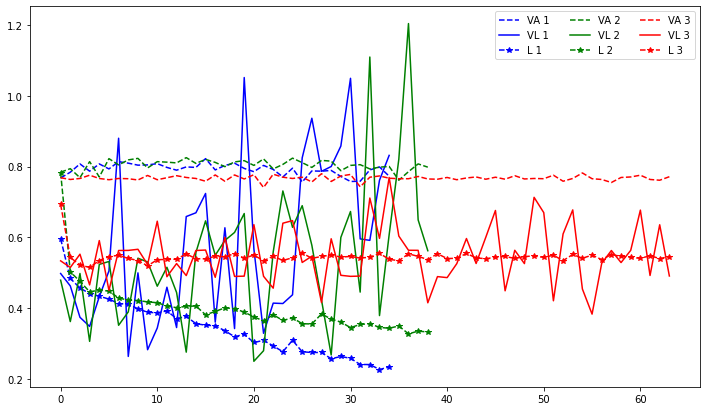

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(H[-3]['val_acc'], 'b--', label='VA 1')
plt.plot(H[-3]['val_loss'], 'b', label='VL 1')
plt.plot(H[-3]['loss'], 'b--*', label='L 1')
plt.plot(H[-2]['val_acc'], 'g--',label='VA 2')
plt.plot(H[-2]['val_loss'], 'g', label='VL 2')
plt.plot(H[-2]['loss'], 'g--*', label='L 2')
plt.plot(H[-1]['val_acc'], 'r--',label='VA 3')
plt.plot(H[-1]['val_loss'], 'r', label='VL 3')
plt.plot(H[-1]['loss'], 'r--*', label='L 3')
plt.legend(ncol=3)
plt.show()

In [ ]:
print(m.metrics_names)
print(m.evaluate_generator(test_generator))

['loss', 'acc']
[0.5636569261550903, 0.8287500143051147]


In [ ]:
m.save('multi_input_64_vgg16_finetune.h5')

In [ ]:
!cp multi_input_64_vgg16_finetune.h5 'drive/My Drive/splus_data/models/multi_input_64_vgg16_finetune.h5'